<a href="https://colab.research.google.com/github/omnihola/Deep-learning-Papers/blob/master/Basic_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**基本CNN神经网络**  
Basic CNN

**Imports**

In [0]:
import time
import numpy as np
import torch
import torch.nn.functional as F
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn as nn

if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True


**Settings and Dataset**

In [4]:
#创建GPU设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#超参
RANDOM_SEED = 1314
LR_RATE = 0.001
NUM_EPOCHS = 10
BATCH_SIZE = 128

#传入参数
NUM_CLASSES = 10


#MNIST数据下载和预处理（transforms）
train_dataset = datasets.MNIST('mnistdata',
                               train=True,
                               transform=transforms.Compose([transforms.ToTensor()]),
                               download=True)

test_dataset = datasets.MNIST('mnistdata',
                               train=False,
                               transform=transforms.Compose([transforms.ToTensor()]),
                               download=True)

#加载数据
train_loader = DataLoader(train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True)

test_loader = DataLoader(test_dataset,
                         batch_size=BATCH_SIZE,
                         shuffle=False)

#验证
for images,indexs in train_loader:
  print('Image batch dimensions:', images.shape)
  print('Image index dimensions:', indexs.shape)
  break


Extracting mnistdata/MNIST/raw/train-images-idx3-ubyte.gz to mnistdata/MNIST/raw


Extracting mnistdata/MNIST/raw/train-labels-idx1-ubyte.gz to mnistdata/MNIST/raw


Extracting mnistdata/MNIST/raw/t10k-images-idx3-ubyte.gz to mnistdata/MNIST/raw




Extracting mnistdata/MNIST/raw/t10k-labels-idx1-ubyte.gz to mnistdata/MNIST/raw
Processing...
Done!
Image batch dimensions: torch.Size([128, 1, 28, 28])
Image index dimensions: torch.Size([128])


In [59]:
for batch_id,(images,labels) in enumerate(train_loader):
  print(images.shape)
  print(labels.shape)
  break

torch.Size([128, 1, 28, 28])
torch.Size([128])


**构建模型**  
**Model**

In [0]:
#简历模型类

class CNN(nn.Module):

  def __init__(self,num_classes):
    super(CNN,self).__init__()

    self.cnn = nn.Sequential(
        nn.Conv2d(1,8,kernel_size=(3,3),stride=1,padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=(2,2),stride=(2,2),padding=0),
        
        nn.Conv2d(8,16,kernel_size=(3,3),stride=1,padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=(2,2),stride=(2,2),padding=0)
    )
    
    self.li_1 = nn.Linear(7*7*16, num_classes)
    # for m in self.modules():
    #   if isinstance(m, torch.nn.Conv2d) or isinstance(m, torch.nn.Linear):
    #     m.weight.data.normal_(0.0, 0.01)
    #     m.bias.data.zero_()
    #       if m.bias is not None:
    #         m.bias.detach().zero_()

  def forward(self,x):
    outs = self.cnn(x)
    
    logits = self.li_1(outs.view(-1,7*7*16))
    prob = F.softmax(logits,dim=1)

    return logits,prob



In [96]:
torch.manual_seed(RANDOM_SEED)

model = CNN(NUM_CLASSES)

#移动到device
model = model.to(device)

#初始化参数
def weight_init(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)
        nn.init.constant_(m.bias, 0)
    # 也可以判断是否为conv2d，使用相应的初始化方式 
    elif isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')

model.apply(weight_init)

CNN(
  (cnn): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (li_1): Linear(in_features=784, out_features=10, bias=True)
)

In [0]:
#优化器
opitimzer = torch.optim.SGD(model.parameters(),lr=LR_RATE,momentum=0.9)

**训练模型**

In [0]:
#精度
#batch里面的size(0)是第几个


def model_accrancy(model,data_loader):
  correct_prob,num_exmples = 0,0
  for images,labels in data_loader:

    #移动到device
    images = images.to(device)
    labels = labels.to(device)

    logits,prob = model.forward(images)
    _, predicted_label = torch.max(prob,1)
    num_exmples += labels.size(0)
    correct_prob += (predicted_label == labels).sum() #矩阵求和
  
  return correct_prob.float()/num_exmples * 100




In [99]:
i = 0
for batch_id,(images,labels) in enumerate(train_loader):
  i += 1
  # print(images.shape)
  # print(labels.shape)
  # print(len(train_loader))
print(i
      )
train_loader.batch_size

469


128

In [73]:
train_loader.dataset

Dataset MNIST
    Number of datapoints: 60000
    Root location: mnistdata
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )

In [118]:
#训练模型

start_time = time.time()
loss_list = []
accruancy = []
accruancy_epoch = []


for epoch in range(NUM_EPOCHS):
  model = model.train()

  for batch_id,(images,labels) in enumerate(train_loader):

    images = images.to(device)
    labels = labels.to(device)
    
    

    #计算
    logits, prob = model.forward(images)

    _, predicted_label = torch.max(prob,1)

    #计算损失函数
    loss = F.cross_entropy(logits,labels)
    
    #清零
    opitimzer.zero_grad()

    #反向传播
    loss.backward()

    #更新梯度
    opitimzer.step()

    #损失函数
    loss_list.append(loss)

    #计算准确率
    accruancy.append((predicted_label == labels).sum()/BATCH_SIZE)

    if not batch_id % 100:                 # 50*batch
      print ('Epoch: %03d/%03d | Batch %03d/%03d | Loss: %.4f' 
                   %(epoch+1, NUM_EPOCHS, batch_id, 
                     len(train_loader), loss))
      # print(prob.shape)
    
    
  model = model.eval()
  print('Epoch: %03d/%03d training accuracy: %.2f%%' % (
          epoch+1, NUM_EPOCHS, 
          model_accrancy(model, train_loader)))
  print()
    
  print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))

print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))






Epoch: 001/010 | Batch 000/469 | Loss: 2.2561
Epoch: 001/010 | Batch 100/469 | Loss: 2.0645
Epoch: 001/010 | Batch 200/469 | Loss: 1.1316
Epoch: 001/010 | Batch 300/469 | Loss: 0.6272
Epoch: 001/010 | Batch 400/469 | Loss: 0.5734
Epoch: 001/010 training accuracy: 86.99%

Time elapsed: 0.26 min
Epoch: 002/010 | Batch 000/469 | Loss: 0.5741
Epoch: 002/010 | Batch 100/469 | Loss: 0.3828
Epoch: 002/010 | Batch 200/469 | Loss: 0.4084
Epoch: 002/010 | Batch 300/469 | Loss: 0.4912
Epoch: 002/010 | Batch 400/469 | Loss: 0.3873
Epoch: 002/010 training accuracy: 90.22%

Time elapsed: 0.51 min
Epoch: 003/010 | Batch 000/469 | Loss: 0.3405
Epoch: 003/010 | Batch 100/469 | Loss: 0.3815
Epoch: 003/010 | Batch 200/469 | Loss: 0.2592
Epoch: 003/010 | Batch 300/469 | Loss: 0.2992
Epoch: 003/010 | Batch 400/469 | Loss: 0.2625
Epoch: 003/010 training accuracy: 91.66%

Time elapsed: 0.77 min
Epoch: 004/010 | Batch 000/469 | Loss: 0.2971
Epoch: 004/010 | Batch 100/469 | Loss: 0.1738
Epoch: 004/010 | Batch 

In [119]:
with torch.set_grad_enabled(False): # save memory during inference
    print('Test accuracy: %.2f%%' % (model_accrancy(model, test_loader)))

Test accuracy: 96.14%


**可视化**
====

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt

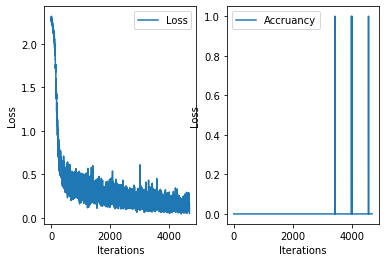

In [123]:
ax1 = plt.subplot(1,2,1)
ax1.plot(range(len(loss_list)), loss_list, label='Loss')
ax1.set_xlabel('Iterations')
ax1.set_ylabel('Loss')
ax1.legend()

ax2 = plt.subplot(1,2,2)
ax2.plot(range(len(accruancy)), accruancy, label='Accruancy')
ax2.set_xlabel('Iterations')
ax2.set_ylabel('Loss')
ax2.legend()
plt.show()

In [92]:
a = list(range(10))
a[3:9:3]

[3, 6]